# Final project IR-WA

Èlia Armengol 205744 Gabriela Cid 206085

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
import math
import collections
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud, ImageColorGenerator
from config import *
import nltk
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import re
from array import array
from numpy import linalg as la
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)

In [2]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import json
import datetime
import re
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))
from nltk.stem import PorterStemmer
porter = PorterStemmer()

## 1 - Data collection

We choose to recollect information from the tweets with the theme Black Lives Matter

In [3]:
# download tweepy

## access token informations 
access_token1 = "2801892334-ahdScaxkY1zLMOX4WpKJRHin470YU0RG7cA7Zxo"
access_token_secret1 = "gktWBlIyJYDaN0R3ST283iYd9coDbZPT505nSZHcmlLmN"

consumer_key1 = "JdxyZOEGkF6IHW5wykjSNd8or"
consumer_secret1 = "43cHQOySq5bzWXV3X7HNjdBi4lSQbi37UOgEAnnj2U2AHttL8R"
bearer = "AAAAAAAAAAAAAAAAAAAAABq5KQEAAAAAmxWRR2sLSoQ%2BKL2L14R4fEDySVI%3Dy1o9dfDqaPzi70HSpYTZjMEoaaPOMjxVWxtXpulZ5z8j1buVr8"

In [4]:
auth = OAuthHandler(consumer_key1, consumer_secret1)
auth.set_access_token(access_token1, access_token_secret1)
api = API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [5]:
class MyStreamListener(StreamListener):
    """
    Twitter listener, collects streaming tweets and output to a file
    """
    def __init__(self, api, OUTPUT_FILENAME, stop_condition=10):
        """
        initialize the stream, with num. of tweets and saving the outputfile
        """
        
        # this line is needed to import the characteristics of the streaming API
        super(MyStreamListener, self).__init__()
        
        # to-count the number of tweets collected        
        self.num_tweets = 0
        
        # save filename
        self.filename = OUTPUT_FILENAME
        
        # stop-condition
        self.stop_condition = stop_condition
        

    def on_status(self, status):
        
        """
        this function runs each time a new bunch of tweets is retrived from the streaming
        """
        
        with open(self.filename, "a+") as f:
            tweet = status._json
            
            f.write(json.dumps(tweet) + '\n')
            #self.output.append(tweet)
            self.num_tweets += 1
        
            # Stop condition        
            if self.num_tweets <= self.stop_condition:
                return True
            else:
                return False
        

    def on_error(self, status):
        """
        function useful to handle errors. It's possible to personalize it 
        depending on the way we want to handle errors
        """
        
        print(status)
        #returning False in on_error disconnects the stream
        return False

In [6]:
%%time

OUTPUT_FILENAME = "data/one.json"
stop_condition = 1500

l = MyStreamListener(api, OUTPUT_FILENAME, stop_condition)
# here we recall the Stream Class from Tweepy to input the authentication info and our personalized listener 
stream = Stream(auth=api.auth, listener=l)


# keywords we may want decide to track 
TRACKING_KEYWORDS = ["#BLM", "#BlackLivesMatter", "#BreonnaTaylor", "#GeorgeFloyd", "black lives", "black", "black people"]
stream.filter(
    track=TRACKING_KEYWORDS, 
    is_async=False, 
    languages = ["en"]
)

Wall time: 2min 13s


## 2 - Build the Search Engine

In [7]:
with open("data/one.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

df_tweets = pd.DataFrame.from_records(data)

df_tweets.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,possibly_sensitive,extended_entities,withheld_in_countries
0,Tue Dec 08 15:30:25 +0000 2020,1336332312020041729,1336332312020041729,RT @dreamaches: Keep signing petitions. Keep d...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 1107351601956610048, 'id_str': '1107351...",None,None,None,None,{'created_at': 'Tue Dec 08 15:09:13 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1607441425696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tue Dec 08 15:30:26 +0000 2020,1336332314737922051,1336332314737922051,RT @quitimbored: casey goodson was an innocent...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,None,"{'id': 1292480243261997056, 'id_str': '1292480...",None,None,None,None,{'created_at': 'Mon Dec 07 19:51:22 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1607441426344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tue Dec 08 15:30:28 +0000 2020,1336332324229693455,1336332324229693455,@wetzelart Arrested? IT'S CALLED FREE SPEECH! ...,"<a href=""http://twitter.com/download/android"" ...",True,1.336320e+18,1336320422711717889,1.235951e+09,1235951318,wetzelart,"{'id': 2884553103, 'id_str': '2884553103', 'na...",None,None,None,None,NaN,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,low,en,1607441428607,"[11, 140]",{'full_text': '@wetzelart Arrested? IT'S CALLE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tue Dec 08 15:30:29 +0000 2020,1336332326913990658,1336332326913990658,RT @INSOMMIAWALLS: HELLOO?!? IS THE TL GONNA B...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 1255675989343993857, 'id_str': '1255675...",None,None,None,None,{'created_at': 'Mon Dec 07 21:57:52 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1607441429247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tue Dec 08 15:30:29 +0000 2020,1336332328147140613,1336332328147140613,"RT @GabrielaToon83: TW // racism, police bruta...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,None,"{'id': 1293186460170899470, 'id_str': '1293186...",None,None,None,None,{'created_at': 'Tue Dec 08 01:13:09 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1607441429541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_tweets = df_tweets[df_tweets['extended_tweet'].notna()]
df_tweets = df_tweets.reset_index(drop=True)
df_tweets = df_tweets.drop(['id', 'id_str'], axis=1)
df_tweets["index"] = df_tweets.index


In [9]:
lines=[]
for i in range(0,len(df_tweets)):
    has= []
    for j in range(0,len(df_tweets['extended_tweet'].values[i]['entities']['hashtags'])):
        has.append(df_tweets['extended_tweet'].values[i]['entities']['hashtags'][j]['text'])
        
    lines.append(str(df_tweets["index"].values[i]) +'|'+
        str(df_tweets['extended_tweet'].values[i]['full_text'])+'|'+
                  str(df_tweets['user'].values[i]['name']) +'|'+ 
                    str(df_tweets['created_at'].values[i]) +'|'+ str(has) +'|'
                + str(df_tweets['favorite_count'].values[i])+'|'+str(df_tweets['retweet_count'].values[i])
                 +'|'+ str(df_tweets['source'].values[i]))


Create the inverted index

In [10]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
    
    # return string   
    return str1  

In [11]:
def remove_accents(text):
    if text:
        # TODO: remove the accents from text (tip: search for unicode)
        return unidecode.unidecode(text)
        
    # In case there is no text
    return ""

def remove_punctuation_marks(text):
    if text:
        # TODO: Remove the punctuation marks from text (tip: search for translate and maketrans)
        return text.translate(str.maketrans('', '', string.punctuation))
    # In case there is no text
    return ""

def text_to_lower_case(text):
    if text:
        # TODO: convert text to lower case
        return text.lower()
    
    # In case there is no text
    return ""

def remove_emojis(text):
    if text:
        # TODO: Remove emojis (tip: search for encode - decode)
        return text.encode('ascii','ignore').decode('ascii')

    # In case there is no text
    return ""

def remove_multiple_whitespaces(text):
    if text:
        # TODO: remove multiple whitespaces (tip: search for regex and replace)
        return re.sub("\s\s+", " ", text)
    # In case there is no text
    return ""



def remove_text_marks(text):
    if text:
        
        #remove @+usernames
        text =  " ".join(filter(lambda x:x[0]!='@', text.split()))
            
        # TODO: replace characters like it\'s by its
        text = re.sub(r"\' ", " ",text)
        
        # TODO: replace *, ?, ... by spaces
        text = re.sub(r'[^\w]', " ",text)
        
        return text.strip()
    
    # In case there is no text
    return ""

def split_text_and_numbers(text):
    return text

def remove_alone_numbers(text):
    if text:
        # TODO: keep only text
        text = re.sub(r"\d", "",text)
        
        return text
    
    return ""

def clean_text(text):
    # Apply the different functions in order to clean the text
    text = text_to_lower_case(text)
    text = remove_text_marks(text)
    text = remove_punctuation_marks(text)
    text = remove_accents(text)
    text = remove_emojis(text)
    text = split_text_and_numbers(text)
    text = remove_alone_numbers(text)
    text = remove_multiple_whitespaces(text)
    
    # Return
    return text

In [12]:
def getTerms(line):
    """
    Preprocess the text removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
        
    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))
    ## START CODE
    line = clean_text(line)
    line= line.split(" ") ## Tokenize the text to get a list of terms
    
    line=[x for x in line if x not in stops]  
    
    
    ##eliminate the stopwords (HINT: use List Comprehension)
    
    line=[stemming.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    
    return line

In [13]:
def create_index(lines):
    """
    Impleent the inverted index
    
    Argument:
    lines -- collection of Wikipedia articles
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    """
    index=defaultdict(list) 
    titleIndex = {} # dictionary to map page titles to page ids
    for line in lines: # Remember, lines contain all documents, each line is a document
        line_arr = line.split("|")
        page_id = int(line_arr[0] )
        terms = getTerms(''.join(line_arr[1:])) #page_title + page_text
        title = line_arr[1]            
        titleIndex[page_id]=title  ## we do not need to apply get terms to title because it used only to print titles and not in the index
        
        ## ===============================================================        
        ## create the index for the current doc and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ...,‘termn’: [currentdoc, [list of positions]]}
        
        ## Example: if the curr_doc has id 1 and his text is 
        ## "web retrieval information retrieval":
        
        ## termdictPage ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}
        
        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================
        
        termdictPage={}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (termdictPage)
                # append the position to the corrisponding list
                
        ## START CODE
                termdictPage[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in python)
            
        #merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
        
        ## END CODE                    
                    
    return index, titleIndex

In [14]:
index, titleIndex = create_index(lines)

In [15]:
print("Index results for the term 'stop': {}\n".format(index['stop']))

Index results for the term 'stop': [[0, array('I', [4])], [7, array('I', [23])], [18, array('I', [18])], [27, array('I', [7])], [72, array('I', [6])], [76, array('I', [14])], [93, array('I', [8])], [112, array('I', [14])], [121, array('I', [10])], [144, array('I', [14])], [156, array('I', [19])], [193, array('I', [8, 29])], [202, array('I', [12])], [229, array('I', [0])], [230, array('I', [4, 22])], [231, array('I', [8])], [247, array('I', [3])], [324, array('I', [1])], [412, array('I', [0])], [448, array('I', [2])], [451, array('I', [12])], [463, array('I', [13])], [507, array('I', [5])], [671, array('I', [15])], [737, array('I', [14])], [754, array('I', [9])], [774, array('I', [7])], [776, array('I', [4])], [800, array('I', [9])], [830, array('I', [0])], [864, array('I', [3])], [930, array('I', [11])], [940, array('I', [12])], [985, array('I', [22])], [1022, array('I', [0])], [1091, array('I', [0])], [1180, array('I', [23])], [1181, array('I', [5])], [1185, array('I', [5])], [1228, a

In [16]:
bag_of_words = {}
for i in titleIndex:
    # remove "RT" string indicating a retweet
    text = titleIndex[i].replace("RT", "").strip()
    
    # lowering text
    text = text.lower()
    
    # removing all the punctuations
    text = re.sub(r'[^\w\s]','',text).strip()
    
    # tokenize the text
    lst_text = text.split()
    
    # remove stopwords
    lst_text = [x for x in lst_text if x not in STOPWORDS]
    
        
    # create bag-of-words - for each word the frequency of the word in the corpus
    for w in lst_text:
        if w not in bag_of_words:
            bag_of_words[w] = 0
        bag_of_words[w] += 1

In [17]:
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

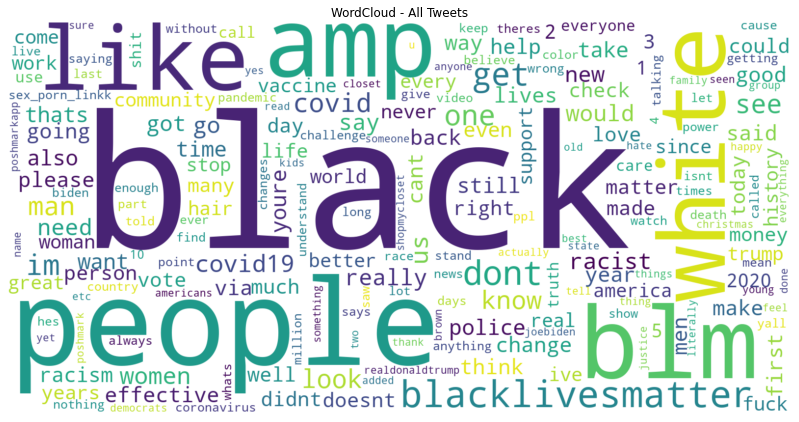

In [18]:
plot_wordcloud("WordCloud - All Tweets", bag_of_words)

<BarContainer object of 9 artists>

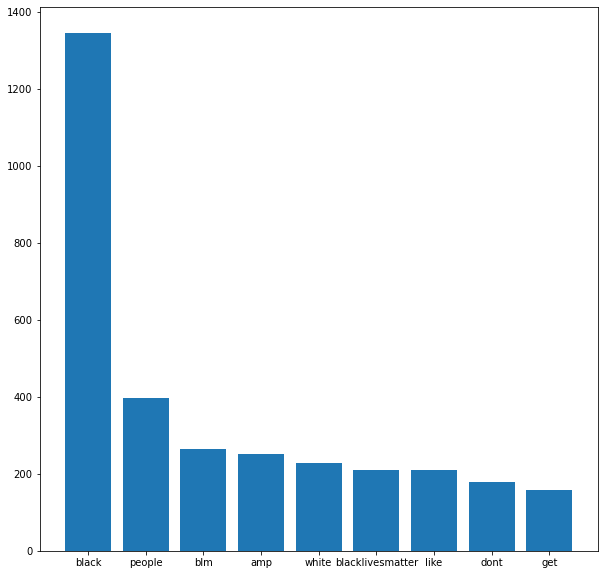

In [19]:
bag_of_words = dict(sorted(bag_of_words.items(), key=lambda item: item[1]))
most_common_words= []
values = []
for i in range(1, 10):
    most_common_words.append(list(bag_of_words)[-i])
    values.append(bag_of_words[list(bag_of_words)[-i]])
#most_common_words
plt.figure(figsize = (10,10))
plt.bar(most_common_words,values)


# Inverted Index

In [20]:
def create_index_tfidf(lines, numDocuments):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    numDocuments -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
        
    index=defaultdict(list)
    tf=defaultdict(list) #term frequencies of terms in documents (documents in the same order as in the main index)
    df=defaultdict(int)         #document frequencies of terms in the corpus
    titleIndex=defaultdict(str)
    idf=defaultdict(float)
    
    for line in lines:
        line_arr = line.split("|")
        page_id = int(line_arr[0] )        
        terms = getTerms(''.join(line_arr[1:])) #page_title + page_text
        title = line_arr[1]            
        titleIndex[page_id]=title          
        
        ## ===============================================================        
        ## create the index for the **current page** and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ...,‘termn’: [currentdoc, [list of positions]]}
        
        ## Example: if the curr_doc has id 1 and his text is 
        ## "web retrieval information retrieval":
        
        ## termdictPage ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}
        
        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

       
        termdictPage={}

        for position, term in enumerate(terms): ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corrisponding list
                termdictPage[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in python)
                
        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm=0
        for term, posting in termdictPage.items(): 
            # posting is a list containing doc_id and the list of positions for current term in current document: 
            # posting ==> [currentdoc, [list of positions]] 
            # you can use it to inferr the frequency of current term.
            norm+=len(posting[1])**2
        norm=math.sqrt(norm)


        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))  ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term]+= 1  # increment df for current term
        
        #merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
            
        # Compute idf following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(numDocuments/df[term])),4)
            
    return index, tf, df, idf, titleIndex


In [21]:
start_time = time.time()
numDocuments = len(lines)
index, tf, df, idf, titleIndex = create_index_tfidf(lines, numDocuments)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 162.71 seconds


In [22]:
print("Index results for the term 'stop': {}\n".format(index['stop']))

Index results for the term 'stop': [[0, array('I', [4])], [7, array('I', [23])], [18, array('I', [18])], [27, array('I', [7])], [72, array('I', [6])], [76, array('I', [14])], [93, array('I', [8])], [112, array('I', [14])], [121, array('I', [10])], [144, array('I', [14])], [156, array('I', [19])], [193, array('I', [8, 29])], [202, array('I', [12])], [229, array('I', [0])], [230, array('I', [4, 22])], [231, array('I', [8])], [247, array('I', [3])], [324, array('I', [1])], [412, array('I', [0])], [448, array('I', [2])], [451, array('I', [12])], [463, array('I', [13])], [507, array('I', [5])], [671, array('I', [15])], [737, array('I', [14])], [754, array('I', [9])], [774, array('I', [7])], [776, array('I', [4])], [800, array('I', [9])], [830, array('I', [0])], [864, array('I', [3])], [930, array('I', [11])], [940, array('I', [12])], [985, array('I', [22])], [1022, array('I', [0])], [1091, array('I', [0])], [1180, array('I', [23])], [1181, array('I', [5])], [1185, array('I', [5])], [1228, a

# Ranked documents

### TF-IDF + cosine similarity

In [23]:

def rankDocuments(terms, docs, index, idf, tf, titleIndex):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """
        
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for queryVector
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 
        
        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            
            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]  # TODO: check if multiply for idf

    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine siilarity
    # see np.dot
    
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    #print document titles instead if document id's
    #resultDocs=[ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)    
    #print ('\n'.join(resultDocs), '\n')
    return resultDocs

In [24]:
def search_tf_idf(query, index):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=getTerms(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs |= set(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf, titleIndex)   
    return ranked_docs

In [25]:
print("Insert your query:\n")
query = input()
ranked_docs = search_tf_idf(query, index)    
top = 20

print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top] :
    print("page_id= {} - page_title: {}".format(d_id, titleIndex[d_id]))

Insert your query:

gay

Top 20 results out of 16 for the seached query:

page_id= 907 - page_title: @meakoopa As a teen I related to the angry gay witch who wore a lot of black and wanted to end it all. As an adult I relate to everything else. ...Although I am still kind of an angry gay witch.
page_id= 1144 - page_title: @JasmineSW3 Not really. He literally has no point. Almost all the leaders and heroes in black history are straight black MEN. 

Even obama, who i dispise passed GAY MARRIAGE thru executive orders after WYT gays shut it down in california.
page_id= 1521 - page_title: They way the black community treats gay black people is why a lot of y’all experience the shit y’all do how we fighting to be treated as humans but disrespect people who are gay it don’t make sense
page_id= 1370 - page_title: Yea he should have lmaoo...who bully’s more than gay black men? Ever seen one of em fight? Word to my mother I never seen a gay black man lose a fight on Beyoncé internet...they know 

### Our score

In [26]:
def search(query, index):
    '''
    The output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=getTerms(query)
    docs=set()
    for term in query:
    ## START DODE
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            # docs = docs Union termDocs
            docs |= set(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    return docs

In [27]:
print("Insert your query:\n")
query = input()
docs = search(query, index)    
top = 20

print("\n======================\nSample of {} results out of {} for the seached query:\n".format(top, len(docs)))
for d_id in docs[:top] :
    print("page_id= {} - page_title: {}".format(d_id, titleIndex[d_id]))

Insert your query:

gay

Sample of 20 results out of 16 for the seached query:

page_id= 1600 - page_title: @ZariaThaGreat @BarkyBoogz Again, how do u know I didn't use the term in company where it's cool? You so badly want to equalize Tranny and the N word shows you're just some cry baby seeking to be offended all the time....Lets break this down for you and your crew:

Being gay isn't the same as being black.
page_id= 1474 - page_title: Biden is proposing truly diverse Cabinet, with beautiful array of super-qualified Black, Latino, Native American, Gay nominees.

At risk of being non-PC, one might ask, did he seek out most qualified ppl, or most qualified minorities... &amp; is reverse descrim ok, long overdue even?
page_id= 778 - page_title: @DeanBrowningPA Copy, Paste Repeat...Dean Browning is Gay Black Man. This is the same energy that Dean and the Dream Team put into their posts. Blah blah blah.
page_id= 907 - page_title: @meakoopa As a teen I related to the angry gay witch who w